In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import chardet
import matplotlib as mpl

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import nltk
#NLP
import string
import re
%matplotlib inline

In [59]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/rodrigo/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
with open('archive/DisneylandReviews.csv','rb') as raw:
    res = chardet.detect(raw.read(1000000))
res

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}

In [3]:
dfRaw = pd.read_csv('archive/DisneylandReviews.csv', encoding='ISO-8859-1')
dfRaw.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong


In [4]:
dfWork = dfRaw.drop('Review_ID', axis = 1)
dfWork['Year_Month'].replace({'missing':np.nan}, inplace=True)
dfWork['Year_Month'] = pd.to_datetime(dfWork['Year_Month'].fillna(method='ffill'))

What i'm gonna do now is try to understand if there is any relation between the length of the review text and the Rating

In [5]:
dfWork['TextLen'] = dfWork['Review_Text'].map(lambda x: len(x))
dfWork.head()

,Rating,Year_Month,Reviewer_Location,Review_Text,Branch,TextLen
0,4,2019-04-01,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,329
1,4,2019-05-01,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,970
2,4,2019-04-01,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,938
3,4,2019-04-01,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,485
4,4,2019-04-01,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,163


<AxesSubplot:xlabel='Rating'>

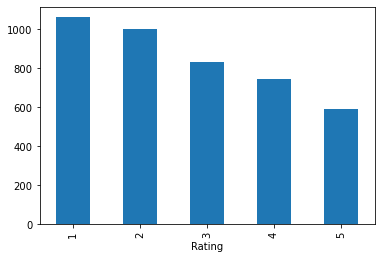

In [6]:
dfWork.groupby('Rating').mean()['TextLen'].plot.bar()

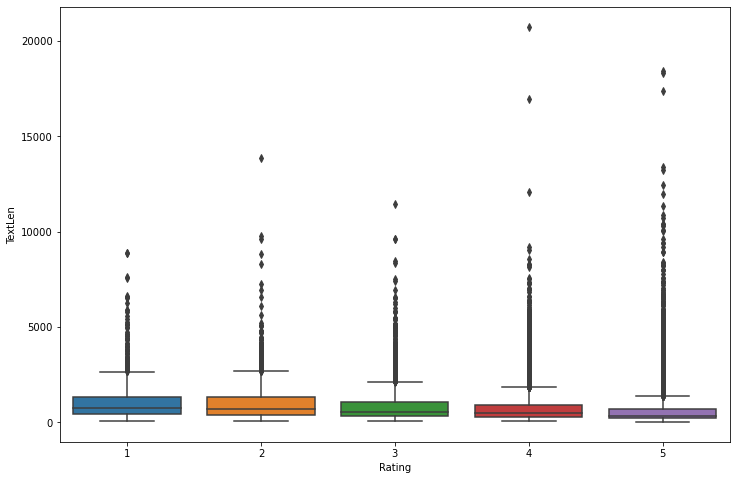

In [7]:
plt.figure(figsize = (12,8))
sns.boxplot(x = 'Rating', y = 'TextLen', data = dfWork)
plt.show()

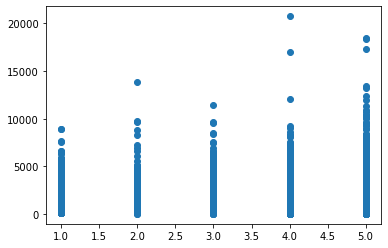

In [8]:
plt.scatter(y = dfWork['TextLen'], x = dfWork['Rating'])

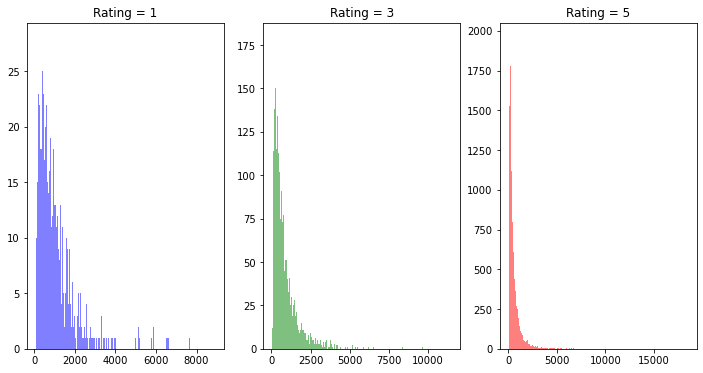

In [9]:
dfRat1 = dfWork[dfWork['Rating'] == 1]
dfRat3 = dfWork[dfWork['Rating'] == 3]
dfRat5 = dfWork[dfWork['Rating'] == 5]
fig, ax = plt.subplots(nrows =1, ncols=3, figsize = (12,6))
ax[0].set_title('Rating = 1')
ax[0].hist(dfRat1['TextLen'], color='b', alpha = 0.5, bins = 500)
ax[1].set_title('Rating = 3')
ax[1].hist(dfRat3['TextLen'], color='g', alpha = 0.5, bins = 500)
ax[2].set_title('Rating = 5')
ax[2].hist(dfRat5['TextLen'], color='r', alpha = 0.5, bins = 500)

plt.show()

It seems like customer who whote longer reviews tend to give lower Ratings

In [10]:
dfWork['NumOfWords'] = dfWork['Review_Text'].str.split().map(lambda x : len(x))
dfWork.head()

,Rating,Year_Month,Reviewer_Location,Review_Text,Branch,TextLen,NumOfWords
0,4,2019-04-01,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,329,59
1,4,2019-05-01,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,970,171
2,4,2019-04-01,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,938,169
3,4,2019-04-01,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,485,91
4,4,2019-04-01,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,163,31


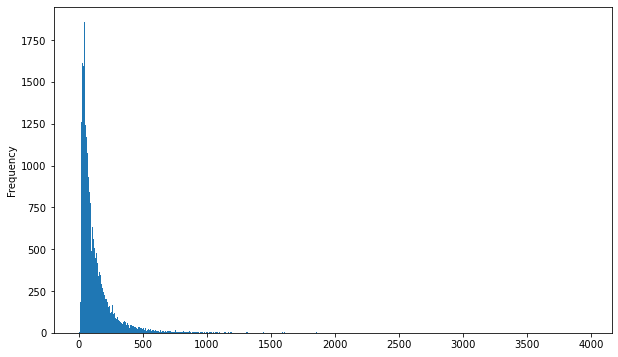

In [11]:
plt.figure(figsize=(10,6))
dfWork['NumOfWords'].plot.hist(bins = 1000);

In [12]:
dfWork['MeanWordLength'] = dfWork['Review_Text'].map(lambda x: np.mean([len(l) for l in str(x).split()]))
dfWork.head()

,Rating,Year_Month,Reviewer_Location,Review_Text,Branch,TextLen,NumOfWords,MeanWordLength
0,4,2019-04-01,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,329,59,4.542373
1,4,2019-05-01,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,970,171,4.678363
2,4,2019-04-01,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,938,169,4.497041
3,4,2019-04-01,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,485,91,4.340659
4,4,2019-04-01,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,163,31,4.225806


<AxesSubplot:xlabel='Rating'>

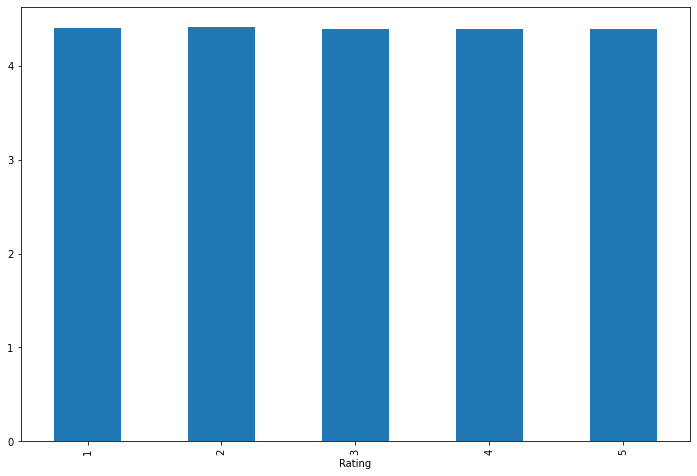

In [13]:
plt.figure(figsize = (12,8))
dfWork.groupby('Rating').mean()['MeanWordLength'].plot.bar()

In [24]:
from nltk.corpus import stopwords

stop = set(stopwords.words("english"))

def removePunctiation(text):
    table =str.maketrans("","", string.punctuation)
    return text.translate(table)

def removeURL(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", text)

def removeStopWords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)

def removeEmojis(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", text)

In [25]:
dfWork['TextTreat'] = dfWork['Review_Text']
dfWork['TextTreat'] = dfWork['Review_Text'].map(removeEmojis)
dfWork['TextTreat'] = dfWork['TextTreat'].map(removeStopWords)
dfWork['TextTreat'] = dfWork['TextTreat'].map(lambda x: removePunctiation(x))
dfWork['TextTreat'] = dfWork['TextTreat'].map(lambda x: removeURL(x))
dfWork.head()

,Rating,Year_Month,Reviewer_Location,Review_Text,Branch,TextLen,NumOfWords,MeanWordLength,TextTreat,tokens
0,4,2019-04-01,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,329,59,4.542373,ever disneyland anywhere find disneyland hong ...,"[ever, disneyland, anywher, find, disneyland, ..."
1,4,2019-05-01,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,970,171,4.678363,since last time visit hk disneyland yet time ...,"[sinc, last, time, visit, hk, disneyland, yet,..."
2,4,2019-04-01,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,938,169,4.497041,thanks god hot humid visiting park otherwise w...,"[thank, god, hot, humid, visit, park, otherwis..."
3,4,2019-04-01,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,485,91,4.340659,hk disneyland great compact park unfortunately...,"[hk, disneyland, great, compact, park, unfortu..."
4,4,2019-04-01,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,163,31,4.225806,location city took around 1 hour kowlon kids l...,"[locat, citi, took, around, 1, hour, kowlon, k..."


In [26]:
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()

def stemming(text):
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text)

In [27]:
dfWork['TextTreat'] = dfWork['TextTreat'].map(stemming)
dfWork.head()

,Rating,Year_Month,Reviewer_Location,Review_Text,Branch,TextLen,NumOfWords,MeanWordLength,TextTreat,tokens
0,4,2019-04-01,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,329,59,4.542373,ever disneyland anywher find disneyland hong k...,"[ever, disneyland, anywher, find, disneyland, ..."
1,4,2019-05-01,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,970,171,4.678363,sinc last time visit hk disneyland yet time st...,"[sinc, last, time, visit, hk, disneyland, yet,..."
2,4,2019-04-01,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,938,169,4.497041,thank god hot humid visit park otherwis would ...,"[thank, god, hot, humid, visit, park, otherwis..."
3,4,2019-04-01,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,485,91,4.340659,hk disneyland great compact park unfortun quit...,"[hk, disneyland, great, compact, park, unfortu..."
4,4,2019-04-01,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,163,31,4.225806,locat citi took around 1 hour kowlon kid like ...,"[locat, citi, took, around, 1, hour, kowlon, k..."


In [28]:
from nltk.tokenize import TreebankWordTokenizer

tokenizer = TreebankWordTokenizer()

dfWork['tokens'] = dfWork['TextTreat'].map(tokenizer.tokenize)

dfWork[["TextTreat",'tokens']].head()

,TextTreat,tokens
0,ever disneyland anywher find disneyland hong k...,"[ever, disneyland, anywher, find, disneyland, ..."
1,sinc last time visit hk disneyland yet time st...,"[sinc, last, time, visit, hk, disneyland, yet,..."
2,thank god hot humid visit park otherwis would ...,"[thank, god, hot, humid, visit, park, otherwis..."
3,hk disneyland great compact park unfortun quit...,"[hk, disneyland, great, compact, park, unfortu..."
4,locat citi took around 1 hour kowlon kid like ...,"[locat, citi, took, around, 1, hour, kowlon, k..."


In [29]:
from sklearn.feature_extraction.text import CountVectorizer

def count_vect(data, ngrams =(1,1)):
    count_vectorizer = CountVectorizer(ngram_range=ngrams)
    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

In [30]:
counts, _ = count_vect(dfWork['TextTreat'])

In [48]:
# now we can do the same for TfidfVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer


def tfidf(data, ngrams=(1, 1)):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=ngrams)
    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

countTfIdf, _ = tfidf(dfWork["TextTreat"], ngrams=(1,2))

In [49]:
X_counts = countTfIdf
y = dfWork['Rating'].values

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_counts, y, test_size=0.3)

In [56]:
modelRF = RandomForestRegressor(n_estimators=100,  n_jobs=-1)

modelRF.fit(X_train, y_train)
modelRF.predict(X_test)

predRF = modelRF.predict(X_test)

In [63]:
print("Plot metrics\n")
print(f"RMSE = {np.sqrt(mean_squared_error(y_test,predRF))}")
print(f"\nMAE = {mean_absolute_error(y_test,predRF)}")
print(f"\RMSLE = {np.sqrt(mean_squared_log_error(y_test,predRF))}")

Plot metrics

RMSE = 0.8499002517392578

MAE = 0.62685564324972
\RMSLE = 0.2118792438168225


In [59]:
import joblib

In [60]:
joblib.dump(modelRF,filename = 'modelRF.joblib')

['modelRF.joblib']

In [61]:
modelLoaded = joblib.load('modelRF.joblib')

In [62]:
pred_loaded =  modelLoaded.predict(X_test)
np.sqrt(mean_squared_error(y_test, pred_loaded))

0.8499002517392578